In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable

from model.alexnet import AlexNet
from model.autoencoder import Autoencoder
from utils.dataset import DatasetFashion

/Users/elisawolia/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
EPOCHS = 5
BATCH_SIZE = 128
DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")

classes_labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
    ]

print(torch.__version__)
print(DEVICE)

2.1.2
cpu


In [3]:
Transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_csv = pd.read_csv('data/fashion/fashion-mnist_train.csv')
test_dataset = pd.read_csv('data/fashion/fashion-mnist_test.csv')

# train_csv = train_csv[0:3000]
# test_dataset = test_dataset[0:500]

train_dataset = train_csv.sample(frac = 0.8)
validation_dataset = train_csv.drop(train_dataset.index)

print(train_dataset.shape)
print(validation_dataset.shape)
print(test_dataset.shape)

(48000, 785)
(12000, 785)
(10000, 785)


In [5]:
train_loader = DataLoader(DatasetFashion(train_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(DatasetFashion(validation_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(DatasetFashion(test_dataset, transform=Transform), batch_size=BATCH_SIZE, shuffle=True)

In [6]:
criterion = F.nll_loss

In [7]:
feature_extr_model = Autoencoder().to(DEVICE)
feature_extr_criterion = nn.MSELoss()
feature_extr_optimizer = torch.optim.AdamW(feature_extr_model.parameters())

In [7]:
feature_extr_model = Autoencoder()
feature_extr_model.load_state_dict(torch.load("./weights.pt"))
feature_extr_model.state_dict()

OrderedDict([('encoder.block1.conv1.weight',
              tensor([[[[-0.1834,  0.1030,  0.0168],
                        [-0.0739, -0.0884,  0.1383],
                        [-0.3070, -0.1014,  0.0966]]],
              
              
                      [[[ 0.3062, -0.2358, -0.3101],
                        [-0.0989, -0.2012,  0.1274],
                        [ 0.0905,  0.2455,  0.1862]]],
              
              
                      [[[ 0.2504,  0.2929, -0.1159],
                        [-0.2283,  0.1655, -0.0071],
                        [-0.1222, -0.2217, -0.2849]]],
              
              
                      [[[-0.1697, -0.3123,  0.1276],
                        [ 0.0783,  0.2056, -0.1198],
                        [ 0.3185,  0.1919,  0.0923]]],
              
              
                      [[[ 0.1347, -0.1281, -0.1534],
                        [-0.0119,  0.2101,  0.1783],
                        [ 0.1050,  0.1215, -0.1700]]],
              
              


In [8]:
def train_encoder(train_loader, epoch, train_losses):
    feature_extr_model.train()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)
        output = feature_extr_model(data)
        loss = feature_extr_criterion(output, data)
        feature_extr_optimizer.zero_grad()
        loss.backward()
        feature_extr_optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.9f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [9]:
def test_encoder(validation_loader, validation_losses):
    feature_extr_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (data, _) in validation_loader:
            data = data.to(DEVICE)
            output = feature_extr_model(data)
            test_loss += feature_extr_criterion(output, data).item()
            pred = output.max(1, keepdim=True)[1]

        test_loss /= len(validation_loader)  
        validation_losses.append(test_loss)
        print("Validation set: Average loss: {:.9f}\n".format(test_loss))
        print('='*50)

In [10]:
# Обучение энкодера на 100% данных

encoder_train_losses = []
encoder_validation_losses = []

for epoch in range(1, EPOCHS+1):
    train_encoder(train_loader, epoch, encoder_train_losses)
    test_encoder(validation_loader, encoder_validation_losses)

Epoch:1 [3712/48000 (8%)]	Loss: 0.096564434
Epoch:1 [7552/48000 (16%)]	Loss: 0.015434095
Epoch:1 [11392/48000 (24%)]	Loss: 0.007866566
Epoch:1 [15232/48000 (32%)]	Loss: 0.005328527
Epoch:1 [19072/48000 (40%)]	Loss: 0.003834194
Epoch:1 [22912/48000 (48%)]	Loss: 0.004337605
Epoch:1 [26752/48000 (56%)]	Loss: 0.003096916
Epoch:1 [30592/48000 (64%)]	Loss: 0.002379427
Epoch:1 [34432/48000 (72%)]	Loss: 0.002042915
Epoch:1 [38272/48000 (80%)]	Loss: 0.001984346
Epoch:1 [42112/48000 (88%)]	Loss: 0.002848082
Epoch:1 [45952/48000 (96%)]	Loss: 0.001951471
Validation set: Average loss: 0.001991367

Epoch:2 [3712/48000 (8%)]	Loss: 0.001360684
Epoch:2 [7552/48000 (16%)]	Loss: 0.002638904
Epoch:2 [11392/48000 (24%)]	Loss: 0.001675588
Epoch:2 [15232/48000 (32%)]	Loss: 0.001313381
Epoch:2 [19072/48000 (40%)]	Loss: 0.001201023
Epoch:2 [22912/48000 (48%)]	Loss: 0.001020916
Epoch:2 [26752/48000 (56%)]	Loss: 0.000888105
Epoch:2 [30592/48000 (64%)]	Loss: 0.001381246
Epoch:2 [34432/48000 (72%)]	Loss: 0.0023741

In [8]:
encoder = feature_extr_model.encoder

In [9]:
def train(model, train_loader, optimizer, epoch, train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if (batch_idx + 1) % 30 == 0:
            print("Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def test(model, validation_loader, validation_losses, validation_accuracy):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(validation_loader.dataset)  
        validation_losses.append(test_loss)
        validation_accuracy.append(100. * correct / len(validation_loader.dataset))
        print("Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(validation_loader.dataset), 100. * correct / len(validation_loader.dataset)))
        print('='*50)

In [15]:
torch.save(feature_extr_model.state_dict(), "./weights.pt")

In [11]:
train_losses = []
validation_losses = []
validation_accuracy = []

model = AlexNet(encoder).to(DEVICE)
for param in model.encoder.parameters():
    param.requires_grad = False
optimizer = optim.Adam(model.parameters())

for epoch in range(1, EPOCHS * 2 + 1):
    train(model, train_loader, optimizer, epoch, train_losses)
    test(model, validation_loader, validation_losses, validation_accuracy)

Epoch:1 [3712/48000 (8%)]	Loss: 1.629991
Epoch:1 [7552/48000 (16%)]	Loss: 1.064424
Epoch:1 [11392/48000 (24%)]	Loss: 0.754155
Epoch:1 [15232/48000 (32%)]	Loss: 0.649315
Epoch:1 [19072/48000 (40%)]	Loss: 0.639616
Epoch:1 [22912/48000 (48%)]	Loss: 0.478132
Epoch:1 [26752/48000 (56%)]	Loss: 0.464294
Epoch:1 [30592/48000 (64%)]	Loss: 0.469970
Epoch:1 [34432/48000 (72%)]	Loss: 0.519059
Epoch:1 [38272/48000 (80%)]	Loss: 0.474233
Epoch:1 [42112/48000 (88%)]	Loss: 0.523594
Epoch:1 [45952/48000 (96%)]	Loss: 0.411043
Validation set: Average loss: 0.4323, Accuracy: 10041/12000 (84%)

Epoch:2 [3712/48000 (8%)]	Loss: 0.343417
Epoch:2 [7552/48000 (16%)]	Loss: 0.313471
Epoch:2 [11392/48000 (24%)]	Loss: 0.328430
Epoch:2 [15232/48000 (32%)]	Loss: 0.347130
Epoch:2 [19072/48000 (40%)]	Loss: 0.391066
Epoch:2 [22912/48000 (48%)]	Loss: 0.266928
Epoch:2 [26752/48000 (56%)]	Loss: 0.474290
Epoch:2 [30592/48000 (64%)]	Loss: 0.383880
Epoch:2 [34432/48000 (72%)]	Loss: 0.308684
Epoch:2 [38272/48000 (80%)]	Loss: 0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


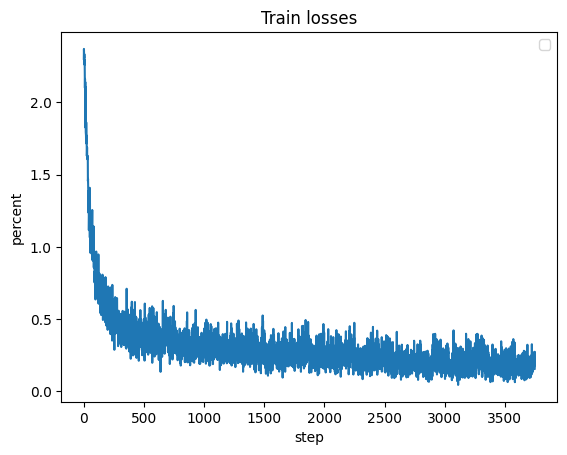

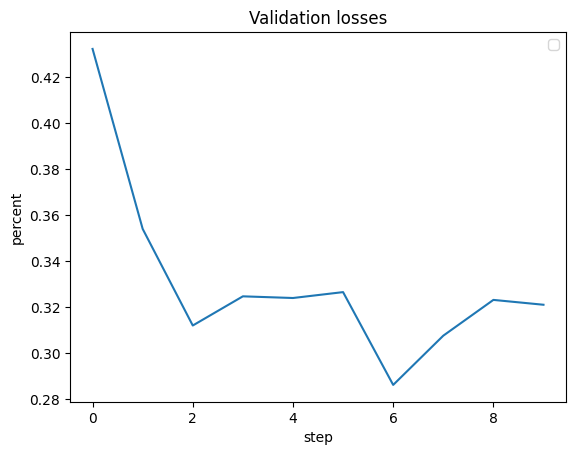

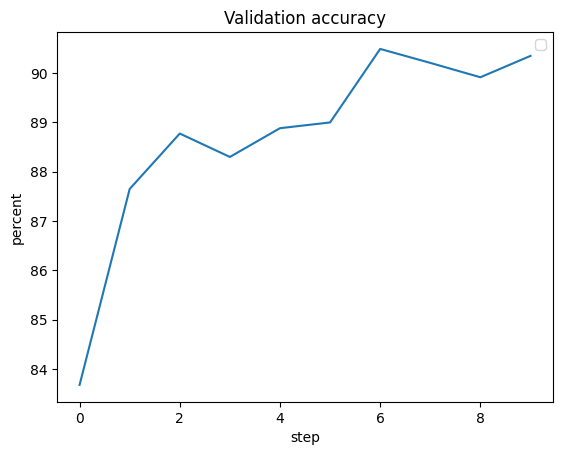

In [12]:
plt.figure()
plt.plot(train_losses)
plt.title('Train losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()


plt.figure()
plt.plot(validation_losses)
plt.title('Validation losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

plt.figure()
plt.plot(validation_accuracy)
plt.title('Validation accuracy')
plt.xlabel('step')
plt.ylabel('percent')
plt.legend()

Accuracy per class:  [0.822 0.991 0.827 0.919 0.879 0.976 0.767 0.952 0.986 0.97 ]
Precision per class:  [0.86526316 0.991      0.87236287 0.90186457 0.84600577 0.97893681
 0.73608445 0.95774648 0.98501499 0.96039604]
Recall per class:  [0.822 0.991 0.827 0.919 0.879 0.976 0.767 0.952 0.986 0.97 ]
F1 per class:  [0.84307692 0.991      0.84907598 0.91035166 0.86218735 0.9774662
 0.75122429 0.95486459 0.98550725 0.96517413]


<Axes: >

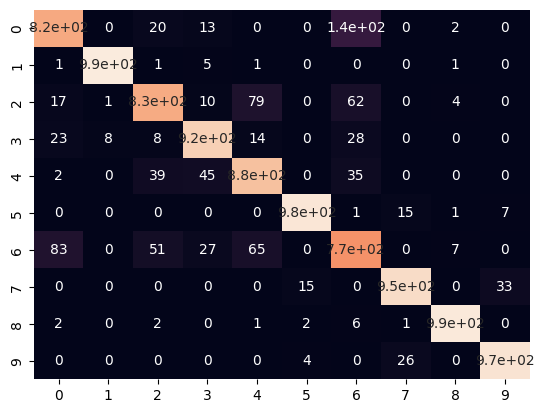

In [13]:
model.eval()

true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

confusion = confusion_matrix(true_labels, predicted_labels)
total_samples_per_class = confusion.sum(axis=1)

print("Accuracy per class: ", confusion.diagonal()/total_samples_per_class)
print("Precision per class: ", precision_score(true_labels,  predicted_labels, average = None))
print("Recall per class: ", recall_score(true_labels,  predicted_labels, average = None))
print("F1 per class: ", f1_score(true_labels,  predicted_labels, average = None))

sns.heatmap(confusion, cbar = False, annot = True)

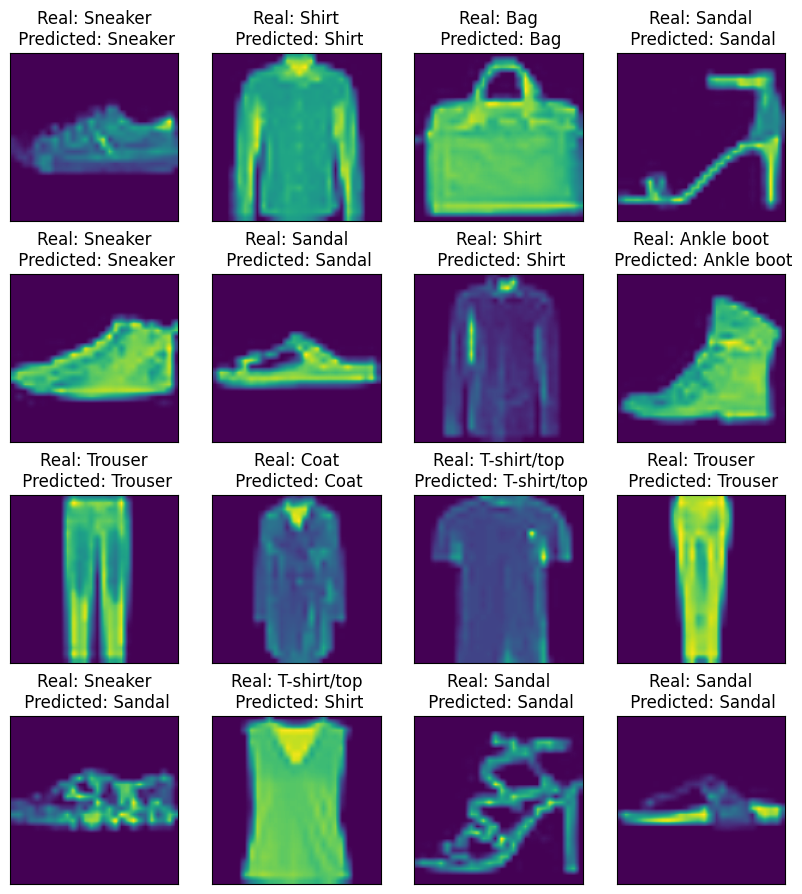

In [14]:
fig = plt.figure(figsize=(10, 11))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = np.transpose(np.array(images[i].to('cpu')), (1,2,0))
    plt.imshow(img/2 + 0.5)
    real_label = classes_labels[labels[i].item()]
    predicted_label = classes_labels[predicted[i].item()]
    ax.set_title(f"Real: {real_label}\n Predicted: {predicted_label}")

plt.show()